```{image} ../thumbnails/arm_logo.png
:alt: ARM Logo
:width: 500px
```

# NOAA Multi-Radar / Multi-Sensor System (MRMS) at the BNF Field Site(s)

## Overview
We'll go through the steps of:

1. Define our region of verification sites
1. Query and Load Data from MRMS Buckets on AWS
1. Create a Multi-Panel Display of QPE for the different sites

## Prerequisites


| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy) | Necessary | Mapping and Tiles |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro/) | Necessary | Familiarity with metadata structure |

- **Time to learn**: 30 minutes
- **System requirements**:
    - Any Operating System
    - At least 8 GB of RAM

## Imports

In [1]:
import cfgrib
import xarray as xr
import fsspec
import glob
import tempfile
import gzip
import geopandas as gpd
import pandas as pd
import numpy as np
import warnings

from cartopy import feature as cfeature
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
from matplotlib.transforms import offset_copy
from matplotlib import pyplot as plt

from metpy.plots import USCOUNTIES

import cmweather

# To ignore all RuntimeWarnings globally
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Hourly QPE BNF Mosaic

The [NOAA Multi-Radar / Multi-Sensor System (MRMS)](https://www.nssl.noaa.gov/projects/mrms/) was created to produce products of preciptiation impacts on transportation and aviation. 

Using the [NOAA MRMS AWS Bucket](https://aws.amazon.com/marketplace/pp/prodview-6odvdc4md2jjc), this notebook details creation of quicklooks to investigate a Quantitative Preciptiation Estimates (QPE) for the U.S. Department of Energy Atmospheric Radiation Measurement (ARM) AMF-3 Deployment to Bankhead National Forest.

We start first with a dictionary containing our sites of interest, these are located Southwest of Decatur, Alabama.

More about the BNF Site can be found on the [ARM Website](https://www.arm.gov/capabilities/observatories/bnf).

In [3]:
global_sites = {"M1" : [34.34525, -87.33842],
                "S4" : [34.46451, -87.23598],
                "S3" : [34.63080, -87.13311],
                "S20" : [34.65401, -87.29264],
                "S30" : [34.38501, -86.92757],
                "S40" : [34.17932, -87.45349]}


# Define a domain to set the extent of the figures
bnf_domain = [272.0, 274.0, 34.1, 35.1]

### Visualize the Site Locations Using Cartopy

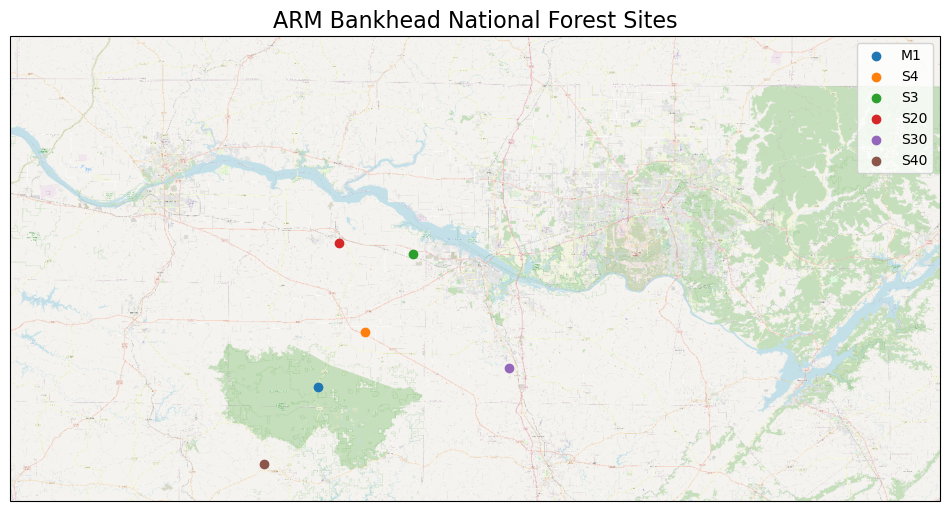

In [4]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ccrs.PlateCarree())

tiler = OSM()
ax.add_image(tiler, 12, zorder=0, alpha=0.7)
for site in global_sites:
    ax.scatter(global_sites[site][1], global_sites[site][0], label=site)

ax.set_extent(bnf_domain)

plt.legend(loc="upper right")
plt.title("ARM Bankhead National Forest Sites", fontsize=16);

## Query and Load Data from MRMS Buckets on AWS

Note the Multi-Sensor (i.e. gauge adjusted) QPE product is split into two categories (Pass 1 and Pass 2), which defines the gauge latency used to adjust radar dervied QPE. 

In [5]:
# Define a Date for Analysis [YYYYMMDD format]
DATE = "20250524"
HOUR = "000000"

In [6]:
## Setup the AWS S3 filesystem
fs = fsspec.filesystem("s3", anon=True)

In [7]:
s3_multi_bucket = [f"s3://noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass1_00.00/{DATE}/*.gz"]
s3_pass2_bucket = [f"s3://noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass2_00.00/{DATE}/*.gz"]
s3_radar_bucket = [f"s3://noaa-mrms-pds/CONUS/RadarOnly_QPE_01H_00.00/{DATE}/*[0-9]0000.grib2.gz"]

### Loop through and Create Lists of Datasets
Our next step is to search, access, and load our data into merged datasets, adding some additional metadata such as units. We apply this for each our our multipass, pass2, and radar datasets.

In [8]:
ds_multi_list = []
for scan in s3_multi_bucket:
    file_path = sorted(fs.glob(scan))
    for mrms in file_path:
        with fs.open(mrms, 'rb') as gzip_file:
            with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
                # Uncompress and read the file
                f.write(gzip.decompress(gzip_file.read()))
                ds = xr.load_dataset(f.name, decode_timedelta=False)
                # Parameters are stored as 'unknown'; meta data in filename
                ds = ds.rename({"unknown" : "multisensor_qpe_1hr"})
                ds["multisensor_qpe_1hr"].attrs["units"] = "mm"
                ds["multisensor_qpe_1hr"].attrs["long_name"] = "Precipitation Accumulation (1-Hr latency)"
                # Subset for the desired bounding box and take out all missing values
                ds = ds.sel(latitude=slice(bnf_domain[3], bnf_domain[2]), longitude=slice(bnf_domain[0], bnf_domain[1])).where(ds.multisensor_qpe_1hr > 0)
                ds_multi_list.append(ds)

In [9]:
ds_radar_list = []
for scan in s3_radar_bucket:
    file_path = sorted(fs.glob(scan))
    for mrms in file_path:
        with fs.open(mrms, 'rb') as gzip_file:
            with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
                # Uncompress and read the file
                f.write(gzip.decompress(gzip_file.read()))
                ds = xr.load_dataset(f.name, decode_timedelta=False)
                ds = ds.rename({"unknown" : "radar_qpe_1hr"})
                ds["radar_qpe_1hr"].attrs["units"] = "mm"
                ds["radar_qpe_1hr"].attrs["long_name"] = "Precipitation Accumulation"
                 # Subset for the desired bounding box and take out all missing values
                ds = ds.sel(latitude=slice(bnf_domain[3], bnf_domain[2]), longitude=slice(bnf_domain[0], bnf_domain[1])).where(ds.radar_qpe_1hr > 0)
                ds_radar_list.append(ds)

In [10]:
ds_pass2_list = []
for scan in s3_pass2_bucket:
    file_path = sorted(fs.glob(scan))
    for mrms in file_path:
        with fs.open(mrms, 'rb') as gzip_file:
            with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
                # Uncompress and read the file
                f.write(gzip.decompress(gzip_file.read()))
                ds = xr.load_dataset(f.name, decode_timedelta=False)
                ds = ds.rename({"unknown" : "multisensor_qpe_pass2"})
                ds["multisensor_qpe_pass2"].attrs["units"] = "mm"
                ds["multisensor_qpe_pass2"].attrs["long_name"] = "Precipitation Accumulation (2-Hr latency)"
                # Subset for the desired bounding box and take out all missing values
                ds = ds.sel(latitude=slice(bnf_domain[3], bnf_domain[2]), longitude=slice(bnf_domain[0], bnf_domain[1])).where(ds.multisensor_qpe_pass2 > 0)
                ds_pass2_list.append(ds)

### Merge our Files Together
Once we have lists of files, we can merge based on the time dimension.

In [11]:
# Concatenate all hourly files into xarray datasets
ds_radar_merged = xr.concat(ds_radar_list, dim="time")
ds_multi_merged = xr.concat(ds_multi_list, dim="time")
ds_pass2_merged = xr.concat(ds_pass2_list, dim="time")

And finally merge our various passes and QPE data into one single dataset.

In [12]:
# Merge Radar, Multi-Sensor Pass 1 and Multi-Sensor Pass 2 QPE into single dataset
ds_merged = xr.merge([ds_radar_merged, ds_multi_merged, ds_pass2_merged])

### Calculate Precipitation Accumulation
Our last step is to calculate our preciptiation accumulation as observed from radar data. We do this by using the xarray cumulative sum [cumsum](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.cumsum.html) function.

In [13]:
# Calculate the Cumulative Distribution
radar_cumulative = ds_merged['radar_qpe_1hr'].cumsum(dim='time')
multisensor = ds_merged['multisensor_qpe_1hr'].cumsum(dim="time")
multisensor_pass2 = ds_merged['multisensor_qpe_pass2'].cumsum(dim="time")

ds_merged['cumulative_radar_qpe'] = radar_cumulative
ds_merged["cumulative_radar_qpe"].attrs["units"] = "mm"
ds_merged["cumulative_radar_qpe"].attrs["long_name"] = "Precipitation Accumulation"

ds_merged['cumulative_multisensor'] = multisensor
ds_merged["cumulative_multisensor"].attrs["units"] = "mm"
ds_merged["cumulative_multisensor"].attrs["long_name"] = "Precipitation Accumulation (1-Hr latency)"

ds_merged['cumulative_ms_pass2'] = multisensor_pass2
ds_merged["cumulative_ms_pass2"].attrs["units"] = "mm"
ds_merged["cumulative_ms_pass2"].attrs["long_name"] = "Precipitation Accumulation (2-Hr latency)"
ds_merged

<xarray.Dataset> Size: 12MB
Dimensions:                 (time: 24, latitude: 100, longitude: 200)
Coordinates:
  * latitude                (latitude) float64 800B 35.1 35.09 ... 34.12 34.11
  * longitude               (longitude) float64 2kB 272.0 272.0 ... 274.0 274.0
  * time                    (time) datetime64[ns] 192B 2025-05-24 ... 2025-05...
    step                    float64 8B 0.0
    heightAboveSea          float64 8B 0.0
    valid_time              (time) datetime64[ns] 192B 2025-05-24 ... 2025-05...
Data variables:
    radar_qpe_1hr           (time, latitude, longitude) float32 2MB nan ... nan
    multisensor_qpe_1hr     (time, latitude, longitude) float32 2MB nan ... nan
    multisensor_qpe_pass2   (time, latitude, longitude) float32 2MB nan ... nan
    cumulative_radar_qpe    (time, latitude, longitude) float32 2MB 0.0 ... 13.3
    cumulative_multisensor  (time, latitude, longitude) float32 2MB 0.0 ... 13.5
    cumulative_ms_pass2     (time, latitude, longitude) float32 2MB 0.0 ... 9.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-08-07T10:27 GRIB to CDM+CF via cfgrib-0.9.1...

## Create a Multi-Panel QPE Display

Now that we have our merged, cleaned data, we can create a single graphic summarizing the cumulative precipitation at our different sites. We use nearest neighbor here to subset from the broader region.

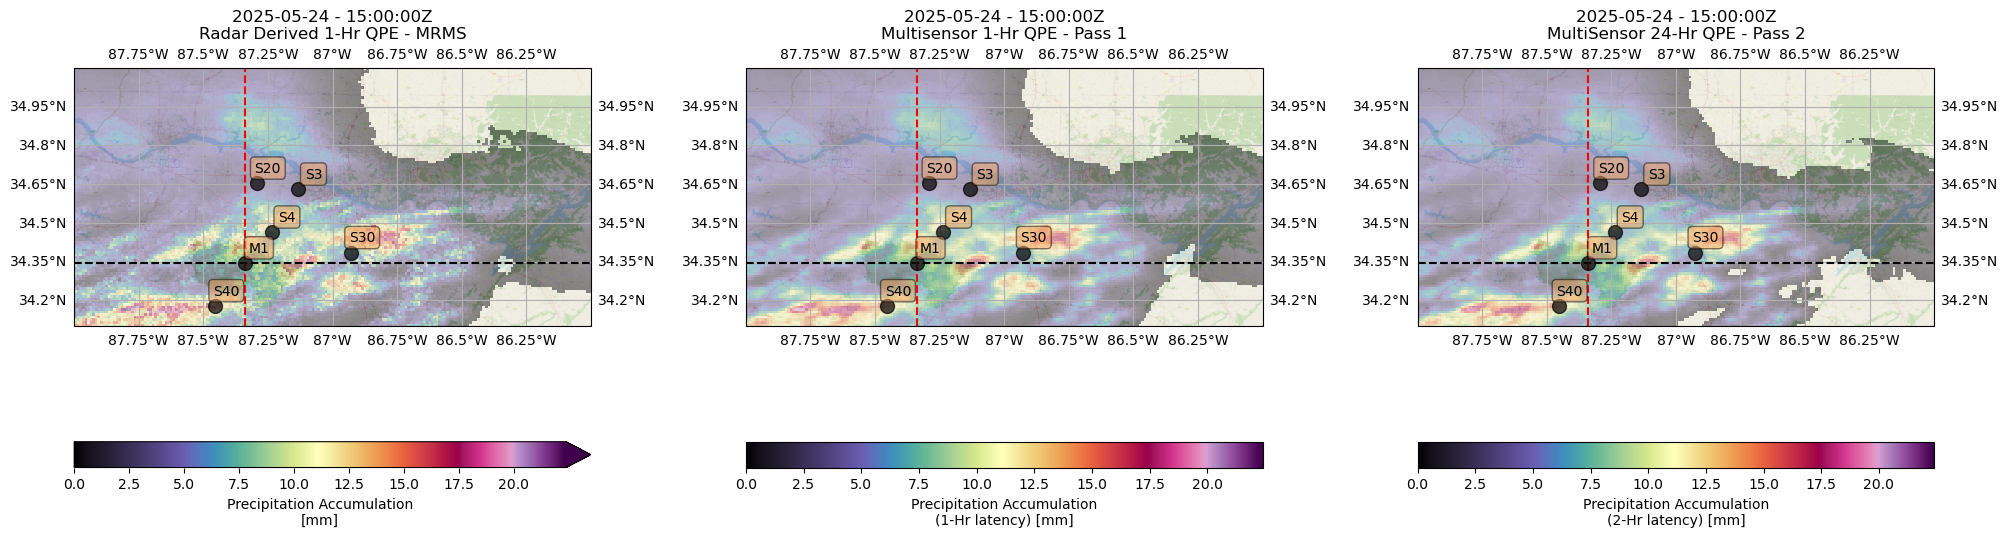

In [14]:
#---------------------------------------------------
# Define the Figure for Detailed Subplot Placement
#---------------------------------------------------
fig = plt.figure(figsize=(24, 10))
tiler = OSM()
mercator = tiler.crs
ax = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())

# adjust the subplot widths
plt.subplots_adjust(wspace=0.3)

# Find the maximum value at each position
da_max = ds_merged.isel(time=-1).radar_qpe_1hr.max()

# Find the minimum value at each position
da_min = 0

# ---------------------------------------------
# Display the Radar Precipitation Accumulation
# ---------------------------------------------

## subset the data
ds_merged.isel(time=15).radar_qpe_1hr.plot(transform=ccrs.PlateCarree(),
                                           ax=ax,
                                           cmap="ChaseSpectral",
                                           vmin=da_min,
                                           vmax=da_max,
                                           cbar_kwargs={"location" : "bottom"})

# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.add_image(tiler, 12, zorder=1, alpha=0.55)
ax.gridlines(draw_labels=True)

# Set plot bounds
ax.set_extent(bnf_domain)

# add in crosshairs to indicate the lat/lon slices
ax.axhline(y=global_sites["M1"][0], color="black", linestyle="--")
ax.axvline(x=global_sites["M1"][1], color="red", linestyle="--")

# Display the location of the BNF supplementarly sites
for key in global_sites:
    # Add a marker for the BNF sites.
    ax.plot(global_sites[key][1], 
            global_sites[key][0], 
            marker='o', 
            color='black', 
            markersize=10, 
            alpha=0.7, 
            transform=ccrs.PlateCarree())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

    # Add text to the right of the symbol.
    ax.text(global_sites[key][1]-0.1, 
            global_sites[key][0], 
            key, 
            verticalalignment='center', 
            horizontalalignment='right', 
            transform=text_transform,
            bbox=dict(facecolor='sandybrown', 
            alpha=0.5, 
            boxstyle='round'))
    
# update the title of the display
ax.set_title(np.datetime_as_string(ds_merged['valid_time'].isel(time=15).data, unit='s').replace("T", " - ") + 
             "Z\n" + "Radar Derived 1-Hr QPE - MRMS")

# ----------------------------
# Display the Multisensor QPE
# ----------------------------
## subset the data
ax1 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
ds_merged.isel(time=15).multisensor_qpe_1hr.plot(transform=ccrs.PlateCarree(),
                                                 ax=ax1,
                                                 cmap="ChaseSpectral",
                                                 vmin=da_min,
                                                 vmax=da_max,
                                                 cbar_kwargs={"location" : "bottom"})

# Add some various map elements to the plot to make it recognizable.
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.BORDERS)
ax1.add_image(tiler, 12, zorder=1, alpha=0.55)
ax1.gridlines(draw_labels=True)

# Set plot bounds
ax1.set_extent(bnf_domain)

# add in crosshairs to indicate the lat/lon slices
ax1.axhline(y=global_sites["M1"][0], color="black", linestyle="--")
ax1.axvline(x=global_sites["M1"][1], color="red", linestyle="--")

# Display the location of the BNF Supplementary Site
for key in global_sites:
    # Add a marker for the BNF sites.
    ax1.plot(global_sites[key][1], 
            global_sites[key][0], 
            marker='o', 
            color='black', 
            markersize=10, 
            alpha=0.7, 
            transform=ccrs.PlateCarree())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax1)
    text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)


    # Add text to the right of the site marker.
    ax1.text(global_sites[key][1]-0.1, 
             global_sites[key][0], 
             key, 
             verticalalignment='center', 
             horizontalalignment='right', 
             transform=text_transform,
             bbox=dict(facecolor='sandybrown', 
             alpha=0.5, 
             boxstyle='round')
    )
    
# update the title of the display
ax1.set_title(np.datetime_as_string(ds_merged['valid_time'].isel(time=15).data, unit='s').replace("T", " - ") + 
             "Z\n" + "Multisensor 1-Hr QPE - Pass 1")

# ----------------------------
# Display the QPE Difference
# ----------------------------
## subset the data
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
ds_merged.isel(time=15).multisensor_qpe_pass2.plot(transform=ccrs.PlateCarree(),
                                                   ax=ax3,
                                                   cmap="ChaseSpectral",
                                                   vmin=da_min,
                                                   vmax=da_max,
                                                   cbar_kwargs={"location" : "bottom"})

# Add some various map elements to the plot to make it recognizable.
ax3.add_feature(cfeature.LAND)
ax3.add_feature(cfeature.OCEAN)
ax3.add_feature(cfeature.BORDERS)
ax3.add_image(tiler, 12, zorder=1, alpha=0.55)
ax3.gridlines(draw_labels=True)

# Set plot bounds
ax3.set_extent(bnf_domain)

# add in crosshairs to indicate the lat/lon slices
ax3.axhline(y=global_sites["M1"][0], color="black", linestyle="--")
ax3.axvline(x=global_sites["M1"][1], color="red", linestyle="--")

# Display the location of the BNF Supplementary Sites
for key in global_sites:
    # Add a marker for the BNF sites.
    ax3.plot(global_sites[key][1], 
            global_sites[key][0], 
            marker='o', 
            color='black', 
            markersize=10, 
            alpha=0.7, 
            transform=ccrs.PlateCarree())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax3)
    text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

    # Add text to the right of the site marker.
    ax3.text(global_sites[key][1]-0.1, 
             global_sites[key][0], 
             key, 
             verticalalignment='center', 
             horizontalalignment='right', 
             transform=text_transform,
             bbox=dict(facecolor='sandybrown', 
             alpha=0.5, 
             boxstyle='round'))
    
# update the title of the display
ax3.set_title(np.datetime_as_string(ds_merged['valid_time'].isel(time=15).data, unit='s').replace("T", " - ") + 
             "Z\n" + "MultiSensor 24-Hr QPE - Pass 2");

## Summary
Within this notebook, we explored plotting a set of a field sites, accessing MRMS data, and visualizing a case over the ARM DOE Bankhead National Forest field site. We hope this serves as a framework for verification and understanding precipitation values in specific regions of interest.

### What's Next
We can extend this workflow by investigating timeseries for the various sites and looking into more robust verification techniques.

## References
- [Notebook originally modified from Joseph O'Brien](https://github.com/ARM-Development/bnf-radar-examples/blob/main/notebooks/bnf-mrms-qpe-hourly.ipynb)
- [NOAA Multi-Radar/Multi-Sensor System (MRMS) was accessed on from https://registry.opendata.aws/noaa-mrms-pds](https://registry.opendata.aws/noaa-mrms-pds)